# PACKAGES

In [1]:

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

 
from PIL import Image
import numpy as np
import os
import pandas as pd
import shutil
import random
import sys
import time


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array



import torch
import torch.nn as nn



In [ ]:
source_path = '/content/drive/MyDrive/Colab Notebooks/Data/Filtered/training/VIRUS'
files = os.listdir(source_path)

print(len(files))




2683
1473


In [ ]:
def move_files(source_path, destination_path):
    files = os.listdir(source_path)
    for file_name in files:
        source_file = os.path.join(source_path, file_name)
        destination_file = os.path.join(destination_path, file_name)
        shutil.move(source_file, destination_file)
        print(f"Moved {file_name} to {destination_path}")

# Example usage
source_path = '/content/drive/MyDrive/Colab Notebooks/Data/Filtered/training/NORMAL/NORMAL_augmented'
destination_path = '/content/drive/MyDrive/Colab Notebooks/Data/Filtered/training/NORMAL'
move_files(source_path, destination_path)

# DATA OVERVIEW

In [ ]:
path = "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY"
files = os.listdir(path)


dfs = []

for file in files:
    if file.endswith(".jpeg"): #DS_store problem
        filename = file
        category = file.split("-")[0] #Filename before - is the category

        df = pd.DataFrame({"Filename": [filename], "Category": [category]})

        dfs.append(df) # Appending to list of dataframes


        
# Concatenate into a single DF 
data_original = pd.concat(dfs, ignore_index=True) 

data_original.head()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


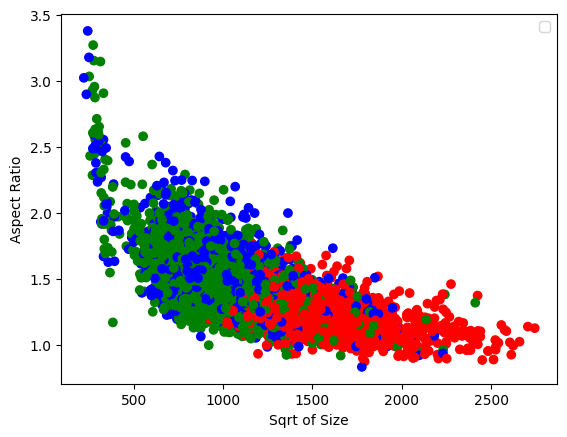

In [ ]:
#List of sizes + aspect ratios
sizes = []
aspects = []


for index, row in data_original.iterrows():        
    
    with Image.open(os.path.join(path, row['Filename'])) as img:
        width, height = img.size
        size = width * height
        aspect = width / height 
        
    #Appending the measurements to the lists created above:
    sizes.append(size)
    aspects.append(aspect) 

# Defining colors for each diagnosis
category_colors = {'BACTERIA': 'green', 'VIRUS': 'blue', 'NORMAL': 'red'}
graph_colors = [category_colors[cat] for cat in data_original.Category]


# Create a scatter plot of the sizes and aspects, colored by category color
plt.scatter(np.sqrt(sizes), aspects, c=graph_colors)
plt.xlabel('Sqrt of Size')
plt.ylabel('Aspect Ratio')
plt.legend()
plt.show()


In [ ]:
# Counting Nr of images per diagnosis

cat_counts = data_original.Category.value_counts()
total=len(data_original)
print(total)


freq_df = pd.DataFrame({'Category': cat_counts.index, 
                        'Frequency': cat_counts.values, 
                        'Percentage': (cat_counts.values/total)*100 })


print(freq_df)

5856
   Category  Frequency  Percentage
0  BACTERIA       2780   47.472678
1    NORMAL       1583   27.032104
2     VIRUS       1493   25.495219


# Filtering on Aspect Ratio Threshold


In [ ]:
path_filtered = "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered"
os.makedirs(path_filtered, exist_ok=True)


for file in os.listdir(path):
     if file.endswith(".jpeg"): #DS_store problem
    
        with Image.open(os.path.join(path, file)) as img:
            width, height = img.size
            aspect = width / height

            
            if aspect <= 3: # Threshold 
                
                #Saving filtered images to output directory
                source_path = os.path.join(path, file)
                output_path = os.path.join(path_filtered, file)
                shutil.copy(source_path, output_path)
            
            
            

In [ ]:
files = os.listdir(path_filtered)
dfs_V2 = []

#Same DF Process as above
for file in files:
    
    if file.endswith(".jpeg"):
       
        filename = file
        category = file.split("-")[0]
        df_temp = pd.DataFrame({"Filename": [filename], "Category": [category]})

        dfs_V2.append(df_temp)


data_filtered = pd.concat(dfs_V2, ignore_index=True)


cat_counts_filtered = data_filtered.Category.value_counts()
total_filtered=len(data_filtered)
print(total_filtered)


freq_df_V2 = pd.DataFrame({'Category': cat_counts_filtered.index, 
                           'Frequency': cat_counts_filtered.values, 
                           'Percentage': (cat_counts_filtered.values/total_filtered)*100 })


print(freq_df_V2)

5849
   Category  Frequency  Percentage
0  BACTERIA       2776   47.461104
1    NORMAL       1583   27.064455
2     VIRUS       1490   25.474440


# SPLITTING INTO TRAIN, VALIDATION AND TEST SETS


In [ ]:
filenames = data_filtered['Filename']
categories = data_filtered['Category']


names_cat = list(zip(filenames, categories))  #List of tuples


#Splitting into train and test (20%) with respect to the categories
train_names_cat, test_names_cat = train_test_split(
    names_cat,
    test_size=0.2,
    stratify=[category for _, category in names_cat],
    random_state=42
)


#Splitting training into train and validation (25%) with respect to the categories
train_names_cat, val_names_cat = train_test_split(
    train_names_cat,
    test_size=0.25,  # 20% of the original training set
    stratify=[category for _, category in train_names_cat],
    random_state=42
)
    

In [ ]:
path_train = "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/training"
path_val= "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/validation"
path_test = "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/testing"

os.makedirs(path_train, exist_ok=True)
os.makedirs(path_val, exist_ok=True)
os.makedirs(path_test, exist_ok=True)



##MOVING THE SETS TO THEIR RESPECTIVE FOLDERS 

for filename, _ in train_names_cat:
    src_path = os.path.join(path2, filename)
    dst_path = os.path.join(path_train, filename)
    shutil.copy(src_path, dst_path)
    

for filename, _ in val_names_cat:
    src_path = os.path.join(path2, filename)
    dst_path = os.path.join(path_val, filename)
    shutil.copy(src_path, dst_path)
    

for filename, _ in test_names_cat:
    src_path = os.path.join(path2, filename)
    dst_path = os.path.join(path_test, filename)
    shutil.copy(src_path, dst_path)
    
    
    

# PREPPING DATA FOR NEURAL MODELS


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#path_train = "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/training"
#path_val= "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/validation"
#path_test = "/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/testing"

path_train='/content/drive/MyDrive/Data/Filtered/training'
path_val='/content/drive/MyDrive/Data/Filtered/validation'
path_test='/content/drive/MyDrive/Data/Filtered/testing'

files = os.listdir(path_train)

i=0

for file in files:
  print(file)


BACTERIA
NORMAL
VIRUS


In [ ]:
#IMAGEDATAGENERATORS
#Normalization + Augmentation

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255) 

In [ ]:
# Flow from directories:

batch_size=32

train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training')

val_generator = val_datagen.flow_from_directory(
    path_val,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='sparse')


Found 10527 images belonging to 3 classes.
Found 1170 images belonging to 3 classes.
Found 1170 images belonging to 3 classes.


# Generating augmented images for plotting

In [ ]:
path_B='/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/training/BACTERIA'
path_V='/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/training/VIRUS'
path_N='/Users/lydiastenflo/Dropbox/My Mac (Magnuss MacBook Air (2))/Desktop/Machine Learning/Projektet/CellData/XRAY/Filtered/training/NORMAL'


path_B_augmented = os.path.join(path_train, 'BACTERIA_augmented')

if not os.path.exists(path_B_augmented):
    os.makedirs(path_B_augmented)


augmented_images = train_datagen.flow_from_directory(
    path_B,
    target_size=(256, 256),
    batch_size=1,
    save_to_dir=path_B_augmented, 
    save_prefix='BACTERIA_augmented'
)


# Visualize augmented images
#fig, axs = plt.subplots(2, 5, figsize=(10, 5))
#fig.suptitle('Augmented Images')

for i in range(1666*2):
    image, label = next(augmented_images)

    #axs[i // 5, i % 5].imshow(image[0])
    #axs[i // 5, i % 5].axis('off')
    #axs[i // 5, i % 5].set_title(f'Class: {label.argmax()}')

#plt.tight_layout()
#plt.show()
#

Found 1666 images belonging to 1 classes.


In [ ]:


#Defined by Keras ImageDataGenerator:
augmentation_types = {
    0: 'Rotation',
    1: 'Width shift',
    2: 'Height shift',
    3: 'Rotation',
    4: 'Zoom',
    8: 'Brightness'
}

# Get the corresponding diagnosis of each augmented image
diagnosis = list(augmented_images.class_indices.keys())



# Visualize:
fig, axs = plt.subplots(1, 5, figsize=(10, 5))
fig.suptitle('Augmented X-rays from the Training set')


for i, ax in enumerate(axs.flat):
    if i >= 5:
       break
    image, label = next(augmented_images)
    ax.imshow(image[0])
    ax.axis('off')
    ax.set_title(f'Diagnosis: {diagnosis[label.argmax()]}\nAugmentation: {augmentation_types[i]}', fontsize=10) #\nAugmentation: {augmentation_types[i]}

plt.tight_layout()
plt.show()

# SVM MODEL

In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

def extract_features(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    features = resnet_model.predict(img)
    features = np.reshape(features, (features.shape[0], -1))
    return features


94765736/94765736 [==============================] - 5s 0us/step


In [6]:
start_time = time.time()

# Load and extract features from the training set
train_features = []
train_labels = []

# Iterate over the categories
for category in os.listdir(path_train):
    category_dir = os.path.join(path_train, category)
    # Iterate over the image files in each category
    for filename in os.listdir(category_dir):
          image_path = os.path.join(category_dir, filename)
          
          # Extract features from the image using your desired method
          features = extract_features(image_path)
          
          # Append the features and corresponding label to the lists
          train_features.append(features)
          train_labels.append(category)

# Convert the lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)


#Time:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
Execution time: 974.1780171394348 seconds


In [7]:
# Convert the lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)


#Time:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#868.9686222076416 seconds

Execution time: 1018.3082568645477 seconds


In [8]:
print(len(train_features))

10527


In [9]:
start_time = time.time()

# Load and extract features from the validation set
val_features = []
val_labels = []

# Iterate over the categories
for category in os.listdir(path_val):
    category_dir = os.path.join(path_val, category)

    # Iterate over the image files in each category
    for filename in os.listdir(category_dir):
        image_path = os.path.join(category_dir, filename)
        
        # Extract features from the image using your desired method
        features = extract_features(image_path)
        
        # Append the features and corresponding label to the lists
        val_features.append(features)
        val_labels.append(category)

# Convert the lists to numpy arrays
val_features = np.array(val_features)
val_labels = np.array(val_labels)

#Time:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Execution time: 110.98661398887634 seconds


1/1 [==============================] - 0s 25ms/step
Execution time: 119.06822967529297 seconds


In [10]:
start_time = time.time()


# Load and extract features from the testing set
test_features = []
test_labels = []

# Iterate over the categories
for category in os.listdir(path_test):
    category_dir = os.path.join(path_test, category)
    
    # Iterate over the image files in each category
    for filename in os.listdir(category_dir):
        image_path = os.path.join(category_dir, filename)
        
        # Extract features from the image using your desired method
        features = extract_features(image_path)
        
        # Append the features and corresponding label to the lists
        test_features.append(features)
        test_labels.append(category)

# Convert the lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)


#Time:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Execution time: 103.11684131622314 seconds


1/1 [==============================] - 0s 24ms/step
Execution time: 123.92890548706055 seconds


In [ ]:
start_time = time.time()

# Convert feature lists to NumPy arrays
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

# Flatten the feature arrays
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Define the SVM model
svm_model = SVC()

# Define the hyperparameters to tune
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
}

# Perform grid search for kernel selection
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(train_features_flat, train_labels)

# Get the best kernel and the best SVM model
best_kernel = grid_search.best_params_['kernel']
best_svm_model = grid_search.best_estimator_

# Fit the best SVM model on the training data
best_svm_model.fit(train_features_flat, train_labels)

# Evaluate the best SVM model on the validation set
val_accuracy = best_svm_model.score(val_features_flat, val_labels)

# Evaluate the best SVM model on the test set
test_accuracy = best_svm_model.score(test_features_flat, test_labels)

# Print the best kernel and the accuracy on the validation and test sets
print(f"Best kernel: {best_kernel}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")

#Time:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


In [11]:

start_time = time.time()


# Define the SVM model
svm_model = SVC(kernel='rbf')

# Fit the SVM model on the training data
svm_model.fit(train_features_flat, train_labels)

# Evaluate the SVM model on the validation set
val_accuracy = svm_model.score(val_features_flat, val_labels)

# Evaluate the SVM model on the test set
test_accuracy = svm_model.score(test_features_flat, test_labels)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

#Time:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Validation Accuracy: 0.8495726495726496
Test Accuracy: 0.8179487179487179
Execution time: 5112.204740285873 seconds


In [13]:
#Predictions using the SVM model

start_time = time.time()
predictions = svm_model.predict(test_features_flat)

# Print the predicted class labels
for i in range(len(predictions)):
    print(f"Image Index: {i}, Predicted Class: {predictions[i]}")
    

#Time:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Image Index: 0, Predicted Class: BACTERIA
Image Index: 1, Predicted Class: BACTERIA
Image Index: 2, Predicted Class: BACTERIA
Image Index: 3, Predicted Class: BACTERIA
Image Index: 4, Predicted Class: BACTERIA
Image Index: 5, Predicted Class: BACTERIA
Image Index: 6, Predicted Class: BACTERIA
Image Index: 7, Predicted Class: VIRUS
Image Index: 8, Predicted Class: VIRUS
Image Index: 9, Predicted Class: VIRUS
Image Index: 10, Predicted Class: BACTERIA
Image Index: 11, Predicted Class: BACTERIA
Image Index: 12, Predicted Class: VIRUS
Image Index: 13, Predicted Class: BACTERIA
Image Index: 14, Predicted Class: BACTERIA
Image Index: 15, Predicted Class: BACTERIA
Image Index: 16, Predicted Class: BACTERIA
Image Index: 17, Predicted Class: BACTERIA
Image Index: 18, Predicted Class: BACTERIA
Image Index: 19, Predicted Class: BACTERIA
Image Index: 20, Predicted Class: BACTERIA
Image Index: 21, Predicted Class: BACTERIA
Image Index: 22, Predicted Class: BACTERIA
Image Index: 23, Predicted Class:

In [16]:
#Model Exploration SVM

# F1-scores:
f1_scores = f1_score(test_labels, predictions, average=None)

# Get class names:
class_names = list(test_labels)

# Classification report:
report = classification_report(test_labels, predictions)
print(report)


              precision    recall  f1-score   support

    BACTERIA       0.79      0.89      0.84       555
      NORMAL       0.92      0.97      0.94       317
       VIRUS       0.72      0.53      0.61       298

    accuracy                           0.82      1170
   macro avg       0.81      0.80      0.80      1170
weighted avg       0.81      0.82      0.81      1170



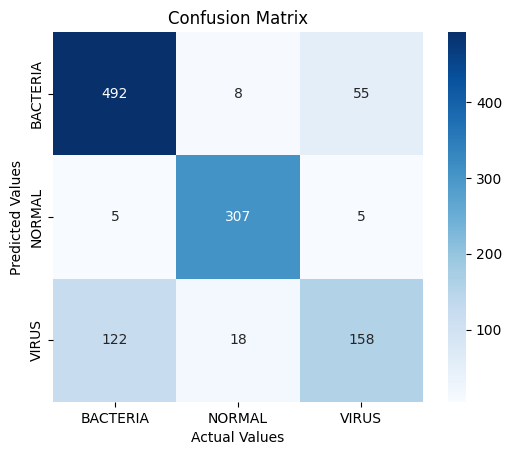

In [23]:

# Confusion matrix:
svm_cm = confusion_matrix(test_labels, predictions)

# Get the unique class labels
class_labels = np.unique(np.concatenate((test_labels, predictions)))

# Visualize the confusion matrix
sns.heatmap(svm_cm,annot=True, fmt='d', cmap='Blues', cbar=True, square=True,)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, ha='center')
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, va='center')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')
plt.show()

# FIRST CNN MODEL

In [ ]:
start_time = time.time()


#CREATING THE MODEL
model_1 = Sequential([
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])


#Compiling
model_1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

epochs=15

#Training the model
history = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping]
)


#EVALUATING on the test set

score = model_1.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


#Getting the time

end_time = time.time()
running_time_model1= end_time - start_time
print("Running time for Model 1: {:.2f} seconds".format(running_time_model1))



Epoch 1/15
328/328 [==============================] - 122s 354ms/step - loss: 1.8026 - accuracy: 0.6083 - val_loss: 0.6070 - val_accuracy: 0.7422
Epoch 2/15
328/328 [==============================] - 115s 349ms/step - loss: 0.7678 - accuracy: 0.6741 - val_loss: 0.6009 - val_accuracy: 0.7422
Epoch 3/15
328/328 [==============================] - 109s 332ms/step - loss: 0.6804 - accuracy: 0.7106 - val_loss: 0.5829 - val_accuracy: 0.7431
Epoch 4/15
328/328 [==============================] - 111s 338ms/step - loss: 0.5639 - accuracy: 0.7527 - val_loss: 0.5968 - val_accuracy: 0.7674
Epoch 5/15
328/328 [==============================] - 114s 348ms/step - loss: 0.4709 - accuracy: 0.7967 - val_loss: 0.5802 - val_accuracy: 0.7604
Epoch 6/15
328/328 [==============================] - 116s 355ms/step - loss: 0.3778 - accuracy: 0.8366 - val_loss: 0.5825 - val_accuracy: 0.7691
Epoch 7/15
328/328 [==============================] - 113s 344ms/step - loss: 0.2996 - accuracy: 0.8709 - val_loss: 0.6080 -

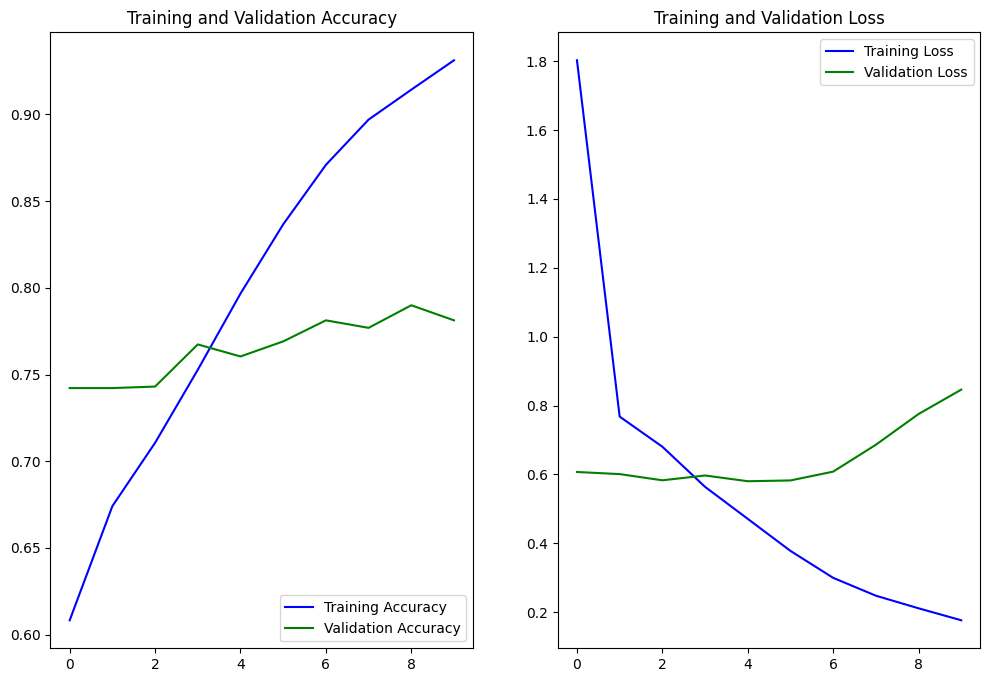

In [ ]:
#Plotting Accuracy and Loss
epochs=10
acc_model1 = history.history['accuracy']
val_acc_model1 = history.history['val_accuracy']
loss_model1=history.history['loss']
val_loss_model1=history.history['val_loss']
epochs_range = range(epochs)



plot_accuracy_and_loss(acc_model1, val_acc_model1, loss_model1, val_loss_model1, epochs_range)



In [ ]:
#Model Exploration

#Model predictions of test set:
test_predictions = model_1.predict(test_generator)
test_predictions = np.argmax(test_predictions, axis=1)

# True labels of test set:
test_labels = test_generator.classes

# F1-scores:
f1_scores = f1_score(test_labels, test_predictions, average=None)

# Get class names:
class_names = list(test_generator.class_indices.keys())

# Classification report:
report = classification_report(test_labels, test_predictions, target_names=class_names)
print(report)


37/37 [==============================] - 20s 534ms/step
              precision    recall  f1-score   support

    BACTERIA       0.48      0.50      0.49       555
      NORMAL       0.27      0.30      0.29       317
       VIRUS       0.24      0.20      0.22       298

    accuracy                           0.37      1170
   macro avg       0.33      0.33      0.33      1170
weighted avg       0.36      0.37      0.36      1170



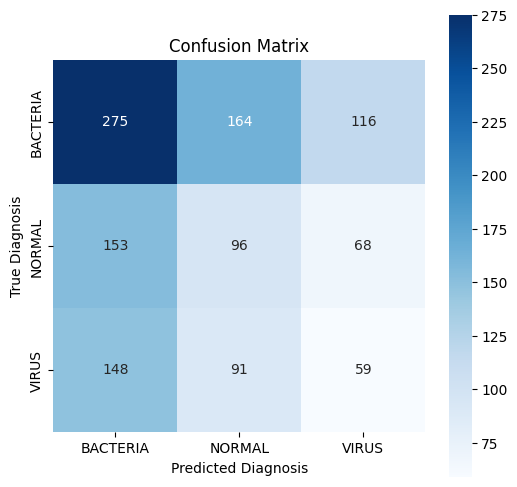

In [ ]:

# Confusion matrix:
plot_confusion_matrix(test_labels, test_predictions, class_names)

# CNN MODEL WITH BATCHNORM AND MORE COMPLEX ARCHITECTURE

In [ ]:


start_time = time.time()


model_2 = Sequential([    
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
    
])



##Compiling
model_2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


#Early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


epochs=15

#Training the model
history = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping]
)



# Evaluating on Test set
score = model_2.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


#Getting the time
end_time = time.time()
running_time_model2 = end_time - start_time
print("Running time for Model 3(Model with BatchNorm): {:.2f} seconds".format(running_time_model2))


Epoch 1/15
328/328 [==============================] - 136s 393ms/step - loss: 2.9466 - accuracy: 0.4921 - val_loss: 29.1464 - val_accuracy: 0.4757
Epoch 2/15
328/328 [==============================] - 126s 385ms/step - loss: 0.9573 - accuracy: 0.5393 - val_loss: 0.8651 - val_accuracy: 0.5573
Epoch 3/15
328/328 [==============================] - 127s 388ms/step - loss: 0.9095 - accuracy: 0.5323 - val_loss: 1.0440 - val_accuracy: 0.6415
Epoch 4/15
328/328 [==============================] - 116s 352ms/step - loss: 0.9080 - accuracy: 0.5493 - val_loss: 1.2434 - val_accuracy: 0.4115
Epoch 5/15
328/328 [==============================] - 119s 363ms/step - loss: 0.8947 - accuracy: 0.5665 - val_loss: 0.6816 - val_accuracy: 0.7109
Epoch 6/15
328/328 [==============================] - 113s 343ms/step - loss: 0.9075 - accuracy: 0.5597 - val_loss: 1.5159 - val_accuracy: 0.4722
Epoch 7/15
328/328 [==============================] - 121s 368ms/step - loss: 0.8672 - accuracy: 0.5763 - val_loss: 1.1654 

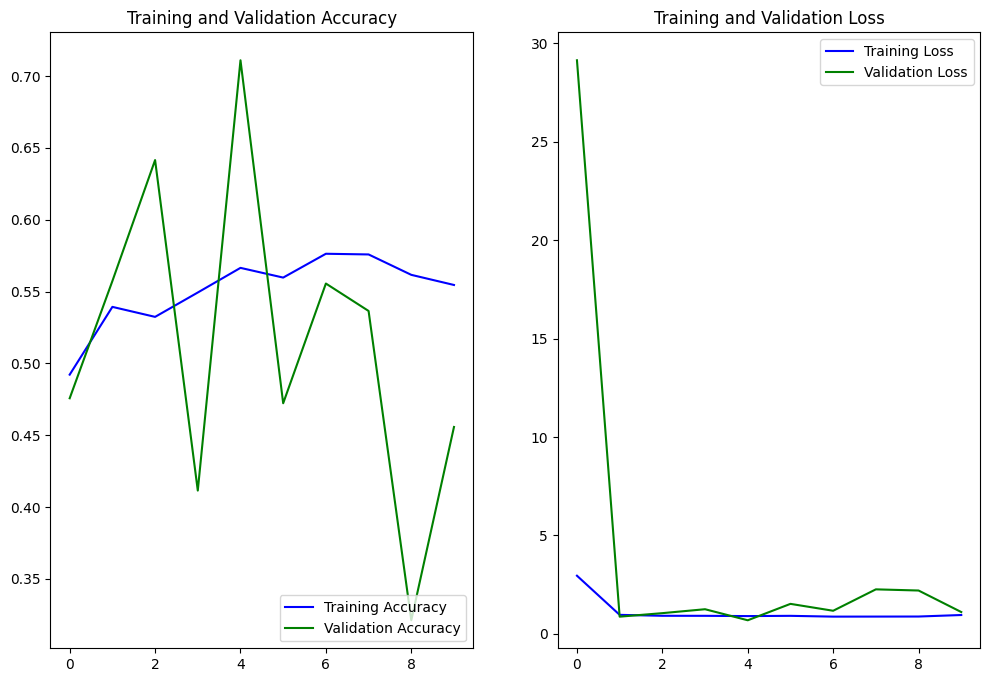

In [ ]:
#Plotting accuracy and loss:
acc_model2 = history.history['accuracy']
val_acc_model2 = history.history['val_accuracy']

loss_model2=history.history['loss']
val_loss_model2=history.history['val_loss']

epochs=10
epochs_range = range(epochs)

plot_accuracy_and_loss(acc_model2, val_acc_model2, loss_model2, val_loss_model2, epochs_range)

In [ ]:
#Model Exploration

#Model predictions of test set:
test_predictions = model_2.predict(test_generator)
test_predictions = np.argmax(test_predictions, axis=1)

#True labels of test set:
test_labels = test_generator.classes

#F1-scores:
f1_scores = f1_score(test_labels, test_predictions, average=None)

# Get class names:
class_names = list(test_generator.class_indices.keys())

report = classification_report(test_labels, test_predictions, target_names=class_names)
print(report)




37/37 [==============================] - 17s 467ms/step
              precision    recall  f1-score   support

    BACTERIA       0.47      0.33      0.39       555
      NORMAL       0.27      0.66      0.38       317
       VIRUS       0.00      0.00      0.00       298

    accuracy                           0.33      1170
   macro avg       0.25      0.33      0.26      1170
weighted avg       0.30      0.33      0.29      1170



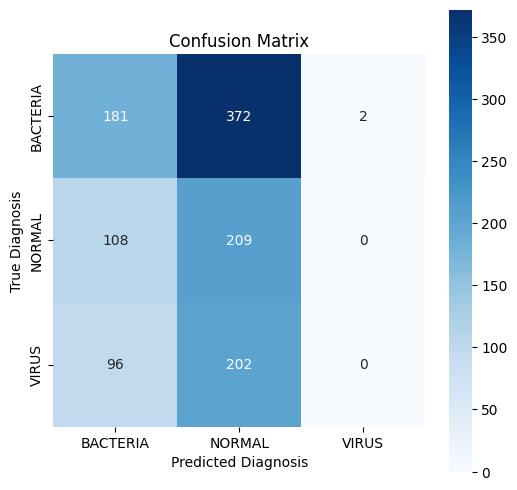

In [ ]:


#Confusion matrix
plot_confusion_matrix(test_labels, test_predictions, class_names)

# ResNet MODEL

In [ ]:
start_time = time.time()

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# The Resnet layers are frozen except for the 10 last ones
for layer in resnet.layers:
    layer.trainable = False
for layer in resnet.layers[-10:]:
    layer.trainable = True

#Resnet model
model_resnet= Sequential([
    resnet,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


# Compiling
model_resnet.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Training the Resnet Model
history = model_resnet.fit(train_generator, 
                    epochs=20, 
                    validation_data=val_generator, 
                    callbacks=[early_stopping])



# Evaluating on Test set
scores = model_resnet.evaluate(test_generator)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])


#Getting the time
end_time = time.time()
running_time_resnet = end_time - start_time
print("Running time for the ResNet Model: {:.2f} seconds".format(running_time_resnet))



94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/20
329/329 [==============================] - 3581s 11s/step - loss: 2.2462 - accuracy: 0.5811 - val_loss: 2.9399 - val_accuracy: 0.4744
Epoch 2/20
329/329 [==============================] - 113s 343ms/step - loss: 0.8236 - accuracy: 0.6315 - val_loss: 0.9184 - val_accuracy: 0.5709
Epoch 3/20
329/329 [==============================] - 116s 352ms/step - loss: 0.8059 - accuracy: 0.6351 - val_loss: 1.2976 - val_accuracy: 0.4838
Epoch 4/20
329/329 [==============================] - 114s 347ms/step - loss: 0.8001 - accuracy: 0.6346 - val_loss: 5.4855 - val_accuracy: 0.2709
Epoch 5/20
329/329 [==============================] - 114s 347ms/step - loss: 0.7979 - accuracy: 0.6271 - val_loss: 2.8027 - val_accuracy: 0.4744
Epoch 6/20
329/329 [==============================] - 114s 346ms/step - loss: 0.7909 - accuracy: 0.6329 - val_loss: 1.3625 - val_accuracy: 0.4803
Epoch 7/20
329/329 [==============================] - 116s 3

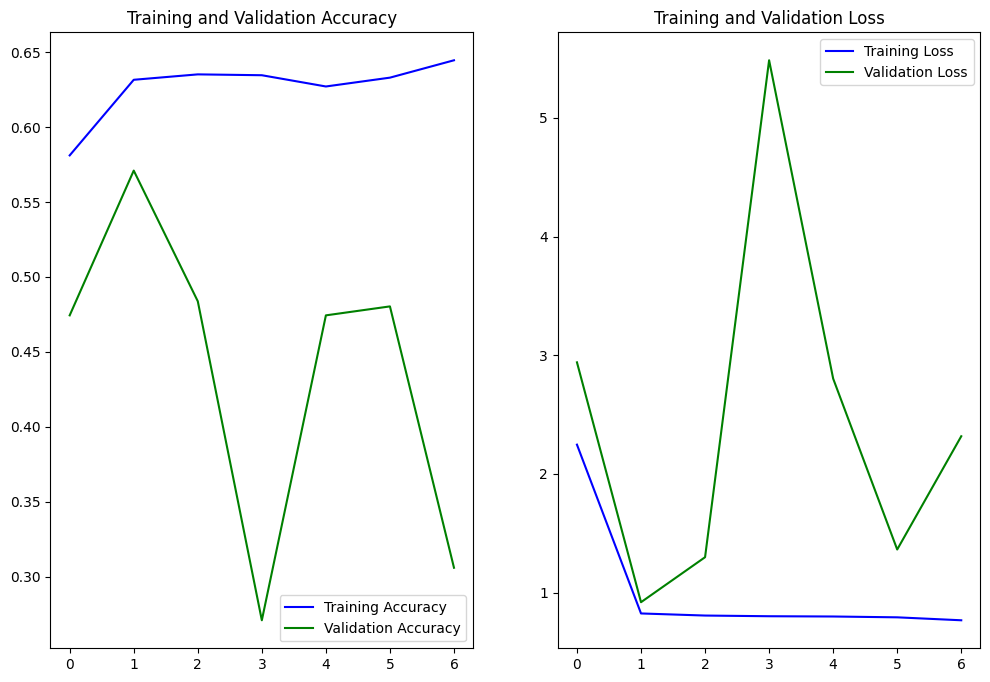

In [ ]:
#Plotting accuracy and loss:
acc_resnet = history.history['accuracy']
val_acc_resnet = history.history['val_accuracy']

loss_resnet=history.history['loss']
val_loss_resnet=history.history['val_loss']

epochs=7
epochs_range = range(epochs)

plot_accuracy_and_loss(acc_resnet, val_acc_resnet, loss_resnet, val_loss_resnet, epochs_range)

In [ ]:
#Model Exploration



#Model predictions of test set:
test_predictions = model_resnet.predict(test_generator)
test_predictions = np.argmax(test_predictions, axis=1)

# True labels of test set:
test_labels = test_generator.classes

# F1-scores:
f1_scores = f1_score(test_labels, test_predictions, average=None)

# Get class names:
class_names = list(test_generator.class_indices.keys())

# Classification report:
report = classification_report(test_labels, test_predictions, target_names=class_names)
print(report)



37/37 [==============================] - 18s 491ms/step
              precision    recall  f1-score   support

    BACTERIA       0.44      0.03      0.05       555
      NORMAL       0.27      0.98      0.43       317
       VIRUS       0.00      0.00      0.00       298

    accuracy                           0.28      1170
   macro avg       0.24      0.34      0.16      1170
weighted avg       0.28      0.28      0.14      1170



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


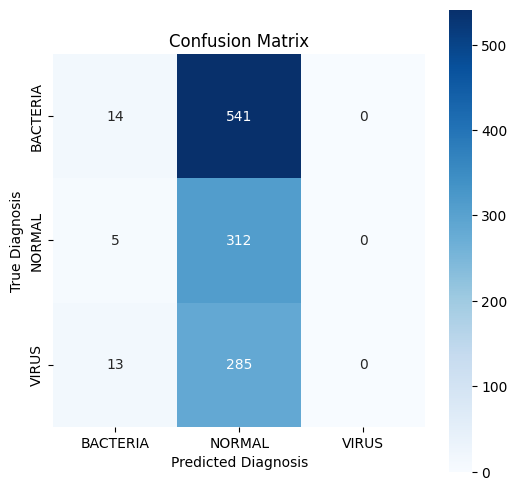

In [ ]:

#Confusion matrix
plot_confusion_matrix(test_labels, test_predictions, class_names)

# PLOTS

In [ ]:
def plot_accuracy_and_loss (acc, val_acc, loss, val_loss, epochs_range):

    plt.figure(figsize=(12, 8))

    # Plot the figure for Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color='blue', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, color='green', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot the figure for Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color='blue', label='Training Loss')
    plt.plot(epochs_range, val_loss, color='green', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
# Running Time Graph


running_time_svm=4


#DONE
running_time_resnet= 4821.71 #kompensera för epoch 1??
running_time_model2=1315.81
running_time_model1=1366.22



model_names = ['CNN Model 1', 'CNN Model 2', 'ResNet Model', 'SVM Model'] 
running_times=[running_time_model1, running_time_model2, running_time_resnet, running_time_svm]


sorted_running_times, sorted_model_names= zip(*sorted(zip(running_times, model_names)))
plt.bar(sorted_model_names, sorted_running_times)


plt.ylabel('Running Time (seconds)')
plt.title('Running Times of the Models')

plt.show()

In [18]:
# Confusion Matrix 

def plot_confusion_matrix(test_labels, test_predictions, class_labels):
    
    cm = confusion_matrix(test_labels, test_predictions)

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)

    # Set the axis labels and title
    ax.set_xlabel('Predicted Diagnosis')
    ax.set_ylabel('True Diagnosis')
    ax.set_title('Confusion Matrix')

    
    plt.show()